# Reproducing Pober+2014

In this demo, we are going to reproduce the results of 
[Pober2015](http://reionization.org/wp-content/uploads/2015/05/HERA4_sensecalc.pdf), a 
memo which estimated the sensitivity of the HERA array in its ultimate configuration. 
This memo was based on [Pober+2014](https://arxiv.org/pdf/1310.7031.pdf), which looked 
at the sensitivity of a "concept HERA" (which differs somewhat from the final 
instrument), as well as a few other well-known arrays.

The purpose of the demo is firstly to show how to estimate the sensitivity of a 
realistic array in a realistic situation. Secondly, it is a regression test, to ensure
that the results given by the new code are consistent with the original code used in
that memo.

The "reproduction" here is not expected to be exact -- there are several small tweaks 
made in the current version that are not present in the code used for the memo (not to 
mention the code used for Pober+2014, which was not released at the time), for example 
cosmological calculations are done with astropy instead of approximate fitting 
functions. Nevertheless, we expect reasonable consistency when the settings are 
tuned to match the original code. 

<div class="alert alert-info">

A Note On The Source Data

The data to which we compare in this notebook is precisely that used in Pober15. In that
memo, the thermal noise estimates are not presented directly (either as a table or
in plots), and only the ultimate SNR of the entire dataset is shown. We sourced the data
for this notebook by installing and running the original code used for the memo with 
identical settings to those presented in the memo. This cannot be repeated easily
since the original code requires Python <= 2. We include the resulting thermal 
sensitivities in this repo for posterity.

</div>

In [73]:
import py21cmsense as p21c
from astropy import units as un
from astropy.cosmology.units import littleh
from astropy.cosmology import Planck15
from astropy import constants
import matplotlib.pyplot as plt
import numpy as np

## Original Data

In [2]:
memo_data = np.load('data/hera331drift_mod_0.135.npz')

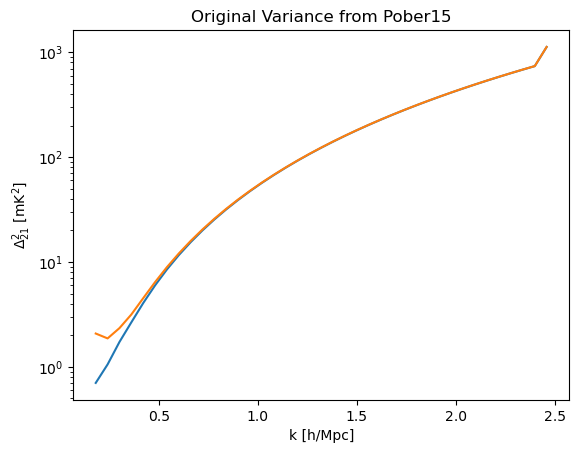

In [3]:
plt.plot(memo_data['ks'], memo_data['T_errs'], label='Thermal Variance')
plt.plot(memo_data['ks'], memo_data['errs'], label='Sample+Thermal Variance')
plt.yscale("log")
plt.title("Original Variance from Pober15")
plt.ylabel(r"$\Delta^2_{21}$ [mK$^2$]")
plt.xlabel("k [h/Mpc]");

## HERA

P15 used a concept version of HERA that was a perfect hexagon (with no split-core), 
with 331 elements and no outriggers. It also used an approximation for the separation
between hexagon rows of 12.12 m, which is close (but not exactly) the same as
$14.0 \sqrt{3}/2$. However, this makes almost no difference to the result, so we leave
the array to be more accurate, with 60 degree angles between antennas on each row. 
Let's create such an array:

In [17]:
hera_ants_p14 = p21c.antpos.hera(hex_num=11, row_separation=12.12*un.m)
hera_ants = p21c.antpos.hera(hex_num=11)


In [19]:
assert hera_ants.shape == (331, 3)

We will reproduce the results at $\nu=135$ MHz (the default case in P15). 
Like P15, we use a dish size of *7 wavelengths at 150 MHz*, which is close to, but not
exactly, 14 m:

In [77]:
beam = p21c.GaussianBeam(frequency=135*un.MHz, dish_size=7 * (constants.c / (150 * un.MHz)).to("m"))

In [79]:
beam.dish_size

<Quantity 13.99031471 m>

Now, let's create the HERA Observatory model. Here, we set the receiver temperature to 100K,
as per Table 1 of P14. We also set the latitude of the instrument to that of Green Bank (38:25:59.24),
which was the assumed location of HERA in P14 & P15:

In [80]:
hera = p21c.Observatory(
    antpos=hera_ants,
    beam=beam,
    latitude=0.6707845*un.rad,
    Trcv=100*un.K,
)

Now, set up the observation itself. Here we assume a sky temperature model of 
$60{\rm K} (\nu/300 {\rm MHz})^{-2.6}$, which is what P15 used (though there is 
no record of it in that memo). 

Furthermore, we set the number of days of observation to 180, with 6 hours per night, 
as described in that memo. 

The coherent observation time in P15 is the "beam crossing time", i.e. the size
of the FWHM of the beam, *at 150 MHz*. In the modern version of the code, the observation
duration is taken to be the FWHM at the *observation* frequency. It is arguable which
of these choices is better, but we set the observation duration to be consistent with
P15 here.

Finally, as per S3.1.2 of P14, we use 8MHz of bandwidth, with 82 channels (providing
~0.1 MHz channel width).

In [119]:
obs = p21c.Observation(
    observatory=hera,
    tsky_amplitude=60*un.K,
    tsky_ref_freq=300*un.MHz,
    spectral_index=2.6,
    n_days=180,
    time_per_day=6*un.hour,
    bandwidth=8*un.MHz,
    n_channels=82,
    integration_time=10.7*un.s, #2077.38*un.s,
    obs_duration=beam.at(150*un.MHz).fwhm.value * 12/np.pi * 3600*un.s,
    use_approximate_cosmo=True,
    cosmo=Planck15.clone(H0=70.0, Om0=0.266)
)

In [120]:
obs.obs_duration.to(un.s)

<Quantity 2077.38126292 s>

In [121]:
obs.uv_coverage.shape

gridding baselines: 100%|██████████| 1260/1260 [00:00<00:00, 14659.17baselines/s]


(41, 41)

Now construct the sensitivity calculation. Here we use the "moderate" foreground model,
with a horizon buffer of 0.1 h/Mpc, as mentioned in P15. The `Legacy21cmFAST` theory 
model is the same model used in the original code.

In [122]:
sense_moderate = p21c.PowerSpectrum(
    observation=obs,
    foreground_model='moderate',
    horizon_buffer=0.1 *littleh/un.Mpc,
    theory_model=p21c.theory.Legacy21cmFAST(),
)

In [123]:
sense1d = sense_moderate.calculate_sensitivity_1d(thermal=True, sample=True)
sense1d_t = sense_moderate.calculate_sensitivity_1d(thermal=True, sample=False)


averaging to 1D: 100%|██████████| 159/159 [00:01<00:00, 150.36kperp-bins/s]


### Plot the resulting comparison

/tmp/ipykernel_15498/2451292649.py:12: RuntimeWarning: invalid value encountered in subtract
  ax[1].plot(memo_data['ks'], 100*(sense1d[:len(memo_data['ks'])].value- memo_data['errs'])/memo_data['errs'])
/tmp/ipykernel_15498/2451292649.py:13: RuntimeWarning: invalid value encountered in subtract
  ax[1].plot(memo_data['ks'], 100*(sense1d_t[:len(memo_data['ks'])].value- memo_data['T_errs'])/memo_data['T_errs'])


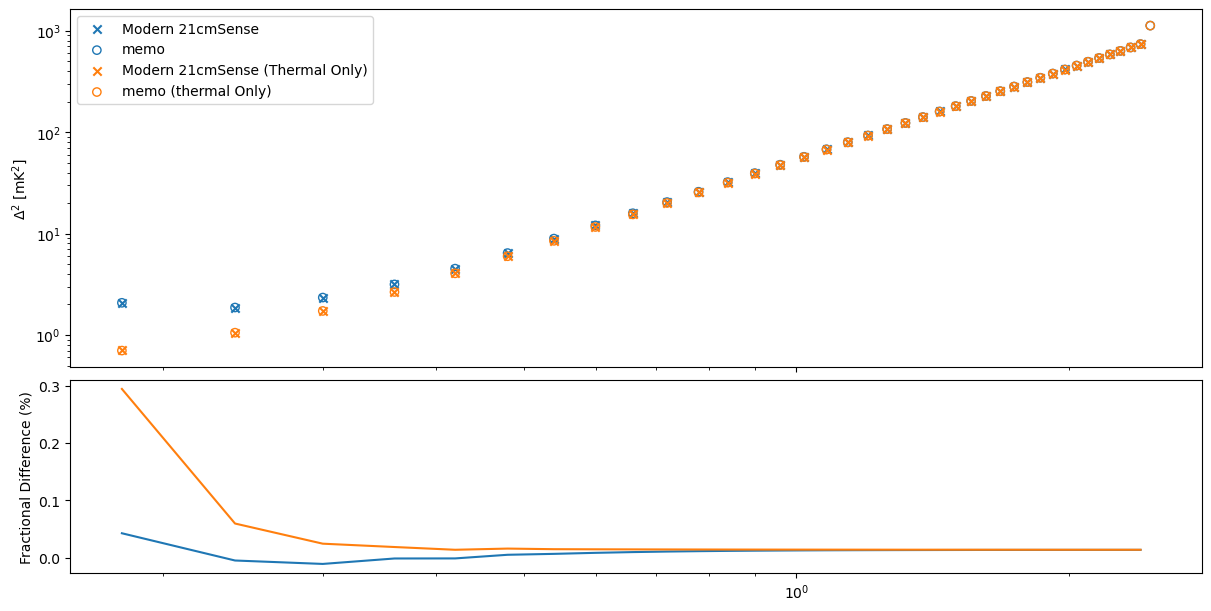

In [124]:
fig, ax = plt.subplots(2, 1, sharex=True, figsize=(12, 6), constrained_layout=True, gridspec_kw={"height_ratios": [0.65, 0.35]})
ax[0].scatter(sense_moderate.k1d, sense1d, label='Modern 21cmSense', marker='x', color='C0')
ax[0].scatter(memo_data['ks'], memo_data['errs'], label='memo', color='C0', lw=1, facecolor='none')

ax[0].scatter(sense_moderate.k1d, sense1d_t, label='Modern 21cmSense (Thermal Only)', marker='x', color='C1')
ax[0].scatter(memo_data['ks'], memo_data['T_errs'], label='memo (thermal Only)', color='C1', facecolor='none')

ax[0].set_yscale("log")
ax[0].set_xscale('log')
ax[0].set_ylabel(r"$\Delta^2$ [mK$^2$]")
ax[1].set_ylabel("Fractional Difference (%)")
ax[1].plot(memo_data['ks'], 100*(sense1d[:len(memo_data['ks'])].value- memo_data['errs'])/memo_data['errs'])
ax[1].plot(memo_data['ks'], 100*(sense1d_t[:len(memo_data['ks'])].value- memo_data['T_errs'])/memo_data['T_errs'])
ax[0].legend();


## Tests

The following are just assertions that the code reproduces the memo data within some
tolerances, as can be seen already by the above plots. This is just for CI testing 
purposes.

In [129]:
mask = ~np.isinf(memo_data['errs'])

assert np.allclose(sense1d[:len(memo_data['ks'])][mask][:-1].value, memo_data['errs'][mask][:-1], rtol=1e-3)
assert np.allclose(sense1d_t[:len(memo_data['ks'])][mask][:-1].value, memo_data['T_errs'][mask][:-1], rtol=5e-3)
